# sprint9 アンサンブル学習、グループワーク

3種類のアンサンブル学習の効果を小さめのデータセットで確認していきます。

- ブレンディング
- バギング
- スタッキング

## 小さなデータセットの用意

この中のtrain.csvをダウンロードし、目的変数としてSalePrice、説明変数として、GrLivAreaとYearBuiltを使います。  
train.csvを学習用（train）8割、検証用（val）2割に分割してください。

### インポート、データ読み込み

In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import pandas as pd
%matplotlib inline
import sys
sys.path.append(
    '/Users/takahashiakira/Documents/DIC/diveintocode-ml/ ml-scratch/model')
sys.path.append(
    '/Users/takahashiakira/Documents/DIC/diveintocode-ml/ ml-scratch/utils')
from decision_region import decision_region2

In [2]:
data = pd.read_csv('train.csv')
y = data.SalePrice
X = data[['YearBuilt', 'GrLivArea']]
# 対数変換する
X = np.log(X)
y = np.log(y)
# 検証データに分ける。
np.random.seed(0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# 【問題1】ブレンディング

ブレンディングを実装し、単一モデルより精度があがる例を最低3つ示してください。  
精度があがるとは、検証用データに対する平均二乗誤差（MSE）が小さくなることを示します。  
ブレンディングとは、N個の多様なモデルを独立して学習させ、推定結果を重み付けした上で足し合わせる方法です。  
最も単純には平均をとります。多様なモデルとは、以下のような条件を変化させることで作り出すものです。  

- 手法（例：線形回帰、SVM、決定木、ニューラルネットワークなど）
- ハイパーパラメータ（例：SVMのカーネルの種類、重みの初期値など）
- 入力データの前処理の仕方（例：標準化、対数変換、PCAなど）  

重要なのはそれぞれのモデルが大きく異なることです。必ずしも単一モデルの精度が高い必要はありません。  
回帰問題でのブレンディングは非常に単純であるため、scikit-learnには用意されていません。

## 手法のブレンド

まずは単体での予測。
それぞれ、線形回帰、SVM、決定木で試す

In [3]:
# パイプライン化
lr = Pipeline([('sc', StandardScaler()), ('lr', LinearRegression())])
# fit predict 評価
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_val)
print('lr_rmse:{}'.format(np.sqrt(mean_squared_error(y_val, lr_pred))))

lr_rmse:0.21425570092305515


In [4]:
#　パイプライン化
svr = Pipeline([('sc', StandardScaler()), ('svc', SVR())])
# fit predict 評価
svr.fit(X_train, y_train)
svr_pred = svr.predict(X_val)
print('svr_rmse:{}'.format(np.sqrt(mean_squared_error(y_val, svr_pred))))

svr_rmse:0.19200046700336174


In [5]:
#　インスタンス化
dtc = DecisionTreeRegressor(max_depth=5)
# fit predict 評価
dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_val)
print('dtc_rmse:{}'.format(np.sqrt(mean_squared_error(y_val, dtc_pred))))

dtc_rmse:0.20659374991510254


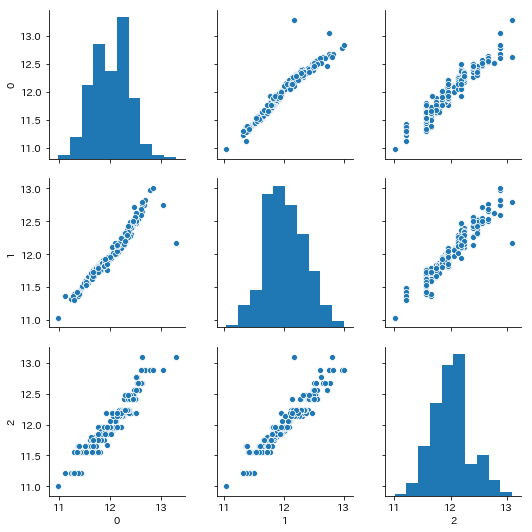

In [6]:
#それぞれの予測結果を可視化
brend_pred = np.vstack([lr_pred, svr_pred, dtc_pred]).T
sns.pairplot(data=pd.DataFrame(brend_pred))

### 結果を単純に混ぜてみる。

In [7]:
brend = lr_pred * 0.15 + svr_pred * 0.5 + dtc_pred * 0.35
print('brend_mse:{}'.format(np.sqrt(mean_squared_error(y_val, brend))))

brend_mse:0.1917293684617085


どのモデルよりも若干精度が良い。

## ハイパーパラメータを変えた物をブレンド

In [8]:
# 線形カーネル
#　パイプライン化
svr1 = Pipeline([('sc', StandardScaler()), ('svc', SVR(kernel='linear',
                                                       C=1e-3))])
# fit predict 評価
svr1.fit(X_train, y_train)
svr_pred1 = svr1.predict(X_val)
print('svr_rmse:{}'.format(np.sqrt(mean_squared_error(y_val, svr_pred1))))

svr_rmse:0.21841167434349307


In [9]:
# polyカーネルでバリバリ過学習
#　パイプライン化
svr2 = Pipeline([('sc', StandardScaler()),
                 ('svc', SVR(kernel='poly', C=1e-4, coef0=1))])
# fit predict 評価
svr2.fit(X_train, y_train)
svr_pred2 = svr2.predict(X_val)
print('svr_rmse:{}'.format(np.sqrt(mean_squared_error(y_val, svr_pred2))))

svr_rmse:0.2762785291392151


In [10]:
# rbfカーネルでバリバリ過学習
#　パイプライン化
svr3 = Pipeline([('sc', StandardScaler()), ('svc', SVR(kernel='rbf', C=100))])
# fit predict 評価
svr3.fit(X_train, y_train)
svr_pred3 = svr3.predict(X_val)
print('svr_rmse:{}'.format(np.sqrt(mean_squared_error(y_val, svr_pred3))))

svr_rmse:0.19803932241383054


In [11]:
brend2 = svr_pred1 * 0.4 + svr_pred2 * 0.15 + svr_pred3 * 0.45
print('brend2_rmse:{}'.format(np.sqrt(mean_squared_error(y_val, brend2))))

brend2_rmse:0.19511700021196896


改善した！

## 入力データの前処理の仕方を変えてみる。

In [12]:
np.random.seed(0)
# データを取得し直す。
y = data.SalePrice
X = data[['YearBuilt', 'GrLivArea']]
# 検証データに分ける。
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

### trainデータに対数変換

In [13]:
# 学習データのみ対数変換
X_train1 = np.log(X_train)
X_val1 = np.log(X_val)

# パイプライン化
lr1 = Pipeline([('sc', StandardScaler()), ('lr', LinearRegression())])
# fit predict 評価
lr1.fit(X_train1, y_train)
lr_pred1 = lr1.predict(X_val1)
print('lr1_rmse:{}'.format(np.sqrt(mean_squared_error(y_val, lr_pred1))))

lr1_rmse:53853.75287591986


### ボックスコックス変換

In [14]:
# ボックスコックス変換
pt = PowerTransformer(method='box-cox')
pt.fit(X_train)

X_train_box = pt.transform(X_train)
X_val_box = pt.transform(X_val)
lr2 = Pipeline([('sc', StandardScaler()), ('lr', LinearRegression())])
# fit predict 評価
lr2.fit(X_train_box, y_train)
lr_pred2 = lr2.predict(X_val_box)
print('lr2_rmse:{}'.format(np.sqrt(mean_squared_error(y_val, lr_pred2))))

lr2_rmse:52934.66311249367


#### 対数変換とボックスコックスの違い

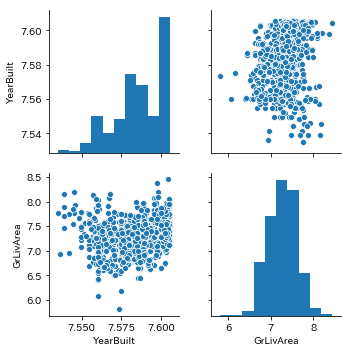

In [15]:
#対数変換後のプロット図
sns.pairplot(data=pd.DataFrame(X_train1))

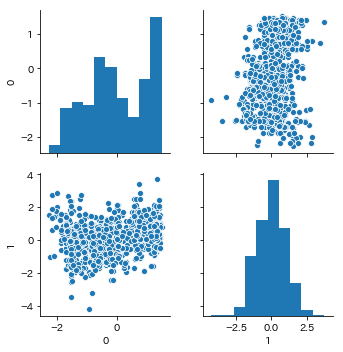

In [16]:
#ボックスコックス変換後のプロット図
sns.pairplot(data=pd.DataFrame(X_train_box))

In [17]:
#シャピロウィルク検定をしてみる。
print('ボックスコックス変換のp値:{}'.format(stats.shapiro(X_train_box[:,1])[1]))
print('対数変換のp値:{}'.format(stats.shapiro(X_train1.GrLivArea)[1]))

ボックスコックス変換のp値:0.006481483578681946
対数変換のp値:0.0033478171098977327


In [18]:
print('ボックスコックスの尖度:{}、対数変換の尖度:{}'.format(pd.Series(X_train_box[:,1]).skew(),X_train1.GrLivArea.skew()))

ボックスコックスの尖度:0.0010623219984493874、対数変換の尖度:-0.06827974061853226


ボックスコックス変換の方が正規っぽい

### 離散値に変換してみる。

In [19]:
X_train_bin = X_train.copy()
X_train_bin['GrLivArea'] = pd.cut(
    X_train.GrLivArea, [0, 1000, 1250, 1500, 1750, 2000, 2500, 3000, 6000],
    labels=False)
X_train_bin['YearBuilt'] = pd.cut(
    X_train.YearBuilt, [1800, 1900, 1950, 1970, 1980, 1990, 2000, 2005, 2100],
    labels=False)

X_val_bin = X_val.copy()
X_val_bin['GrLivArea'] = pd.cut(
    X_val.GrLivArea, [0, 1000, 1250, 1500, 1750, 2000, 2500, 3000, 6000],
    labels=False)
X_val_bin['YearBuilt'] = pd.cut(
    X_val.YearBuilt, [1800, 1900, 1950, 1970, 1980, 1990, 2000, 2005, 2100],
    labels=False)

# こっちは標準化の方法を変える。
# パイプライン化
lr3 = LinearRegression()
# fit predict 評価
lr3.fit(X_train_bin, y_train)
lr_pred3 = lr3.predict(X_val_bin)
print('lr3_rmse:{}'.format(np.sqrt(mean_squared_error(y_val, lr_pred3))))

lr3_rmse:52072.78393447494


### ブレンディング

In [20]:
#ブレンド
brend3 = lr_pred1 * 0.2 + lr_pred2 * 0.3 + lr_pred3 * 0.5
print('brend3_rmse:{}'.format(np.sqrt(mean_squared_error(y_val, brend3))))

brend3_rmse:52071.48017626987


**すこーし改善した。**

# 【問題2】バギング

バギングを実装し、単一モデルより精度があがる例を最低1つ示してください。  
バギングは入力データの選び方を多様化する方法です。  
学習データから重複を許した上でランダムに抜き出すことで、N種類のサブセット（ブートストラップサンプル）を作り出します。  
それらによってモデルをN個学習し、推定結果の平均をとります。  
ブレンディングと異なり、それぞれの重み付けを変えることはありません。

## 決定木のみで学習した場合のスコア

In [21]:
np.random.seed(0)
# データを取得し直す。
y = data.SalePrice
X = data[['YearBuilt', 'GrLivArea']]
# 検証データに分ける。
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [22]:
dtc = DecisionTreeRegressor()
dtc.fit(X_train, y_train)
pred = dtc.predict(X_val)
print('dtc_rmse:{}'.format(np.sqrt(mean_squared_error(y_val, pred))))

dtc_rmse:54277.5259538359


## サンプル数とmax_depth、学習機の数を変えて数種類試す。
## ランダムフォレストのように特徴量は全て使わずランダム抽出

### 1つめ

In [23]:
pred_list = []
n_sample = 0.3  # サンプル数の割合
depth = 2  # マックスデプス
n_iter = 1000  # 学習木の数
np.random.seed(0)

for i in range(n_iter):
    # サンプルをランダム抽出
    random_ind = np.random.choice(len(X_train),
                                  int(len(X_train) * n_sample),
                                  replace=True)
    X_train_ran = X_train.values[random_ind]
    y_train_ran = y_train.values[random_ind]
    # 決定木をインスタンス化
    tree = DecisionTreeRegressor(criterion='mse', max_depth=depth)
    # 使用する特徴量を選ぶ
    feature = int(np.random.rand(1) > 0.5)  # １か０が出る。
    tree.fit(X_train_ran[:, feature].reshape(-1, 1), y_train_ran)  # 学習
    pred = tree.predict(X_val.values[:, feature].reshape(-1, 1))  # 予測
    pred_list.append(pred)  # predをリストに追加していく。

In [24]:
baging_pred = np.mean(pred_list, axis=0)
print('baging_rmse:{}'.format(np.sqrt(mean_squared_error(y_val, baging_pred))))

baging_rmse:56386.981351181246


悪くなった。

### 2つめ

In [25]:
pred_list = []
n_sample = 0.05  # サンプル数の割合
depth = 1
n_iter = 10000
np.random.seed(0)

for i in range(n_iter):
    # サンプルをランダム抽出
    random_ind = np.random.choice(len(X_train),
                                  int(len(X_train) * n_sample),
                                  replace=True)
    X_train_ran = X_train.values[random_ind]
    y_train_ran = y_train.values[random_ind]
    # 決定木をインスタンス化
    tree = DecisionTreeRegressor(max_depth=depth)
    # 使用する特徴量を選ぶ
    feature = int(np.random.rand(1) > 0.5)  # １か０が出る。
    tree.fit(X_train_ran[:, feature].reshape(-1, 1), y_train_ran)  # 学習
    pred = tree.predict(X_val.values[:, feature].reshape(-1, 1))  # 予測
    pred_list.append(pred)

In [26]:
baging_pred = np.mean(pred_list, axis=0)
print('baging_rmse:{}'.format(np.sqrt(mean_squared_error(y_val, baging_pred))))

baging_rmse:61995.67101974898


更に悪くなった。

### 3つ目

In [27]:
from tqdm import tqdm_notebook as tqdm
pred_list = []
n_sample = 0.5  # サンプル数の割合
depth = 5
n_iter = 100
np.random.seed(0)

for i in tqdm(range(n_iter)):
    # サンプルをランダム抽出
    random_ind = np.random.choice(len(X_train),
                                  int(len(X_train) * n_sample),
                                  replace=True)
    X_train_ran = X_train.values[random_ind]
    y_train_ran = y_train.values[random_ind]
    # 決定木をインスタンス化
    tree = DecisionTreeRegressor(max_depth=depth)
    # 使用する特徴量を選ぶ
    feature = int(np.random.rand(1) > 0.5)  # １か０が出る。
    tree.fit(X_train_ran[:, feature].reshape(-1, 1), y_train_ran)  # 学習
    pred = tree.predict(X_val.values[:, feature].reshape(-1, 1))  # 予測
    pred_list.append(pred)

In [28]:
baging_pred = np.mean(pred_list, axis=0)
print('baging_rmse:{}'.format(np.sqrt(mean_squared_error(y_val, baging_pred))))

baging_rmse:53968.303233723615


**精度改善！！**

### 4つ目(特徴量を全て使う。)

In [29]:
pred_list = []
n_sample = 0.1  # サンプル数の割合
depth = 4
n_iter = 10000
np.random.seed(0)

for i in tqdm(range(n_iter)):
    # サンプルをランダム抽出
    random_ind = np.random.choice(len(X_train),
                                  int(len(X_train) * n_sample),
                                  replace=True)
    X_train_ran = X_train.values[random_ind]
    y_train_ran = y_train.values[random_ind]
    # 決定木をインスタンス化
    tree = DecisionTreeRegressor(max_depth=depth)
    tree.fit(X_train_ran, y_train_ran)  # 学習
    pred = tree.predict(X_val.values)  # 予測
    pred_list.append(pred)

In [30]:
baging_pred = np.mean(pred_list, axis=0)
print('baging_rmse:{}'.format(np.sqrt(mean_squared_error(y_val, baging_pred))))

baging_rmse:47079.67347198919


全然こっちの方が良い！！

# 【問題3】スタッキング

スタッキングを実装し、単一モデルより精度があがる例を最低1つ示してください。  
スタッキングの手順は以下の通りです。  
最低限ステージ0とステージ1があればスタッキングは成立するため、それを実装してください。  
まずはK0=3,M0=2程度にします。

**学習時**  
（ステージ 0 ）  
- 学習データを $K_0$ 個に分割する。  
- 分割した内の $(K_0−1)$ 個をまとめて学習用データ、残り 1 個を推定用データとする組み合わせが $K_0$ 個作れる。
- あるモデルのインスタンスを $K_0$ 個用意し、異なる学習用データを使い学習する。  
- それぞれの学習済みモデルに対して、使っていない残り 1 個の推定用データを入力し、推定値を得る。（これをブレンドデータと呼ぶ）  
- さらに、異なるモデルのインスタンスも  $K_0$ 個用意し、同様のことを行う。モデルが $M_0$ 個あれば、 $M_0$ 個のブレンドデータが得られる。  

（ステージ n ）
- ステージ n−1 のブレンドデータを$M_{n−1}$ 次元の特徴量を持つ学習用データと考え、 $K_n$ 個に分割する。以下同様である。

（ステージ N ）＊最後のステージ

- ステージ N−1 の $M_{N−1} 個のブレンドデータを$M_{N−1} 次元の特徴量の入力として、1種類のモデルの学習を行う。
これが最終的な推定を行うモデルとなる。

**推定時**  
（ステージ 0 ）
- テストデータを $K_0×M_0$ 個の学習済みモデルに入力し、$K_0×M_0$ 個の推定値を得る。  
これを $K_0$ の軸で平均値を求め $M_0$ 次元の特徴量を持つデータを得る。（ブレンドテストと呼ぶ）

（ステージ n ）  
- ステージ n−1 で得たブレンドテストを $K_n×M_n$ 個の学習済みモデルに入力し、$K_n×M_n$ 個の推定値を得る。  
これを $K_n$ の軸で平均値を求め $M_0$ 次元の特徴量を持つデータを得る。（ブレンドテストと呼ぶ）  

（ステージ N ）＊最後のステージ

- ステージ N−1 で得たブレンドテストを学習済みモデルに入力し、推定値を得る。

### クラスの作成！

In [33]:
class Stacking_models():
    def __init__(self, base_models, meta_model, n_splits=5):
        """
        スタッキングのクラス。
        Parameters    
        ----------
        base_models:list
            ステージ0でのモデルインスタンスのリスト。
        meta_model:list
            ステージ1でのモデルインスタンス。
        n_splits:int
            分割数
        
        Attributes
        ----------
        oof_pred:次の形のndarray, shape (n_samples, n_models)
            trainデータのステージ1での予測値
        new_feature:次の形のndarray, shape (n_samples, n_models)
            testデータのステージ1での予測値        
        instance:list
            fitした後のモデルのリスト
        """
        self.base_models = base_models
        self.meta_model = meta_model
        self.oof_pred = None
        self.new_feature = None
        self.n_splits = n_splits
        self.fitted_models = {}

    def fit(self, X, y):
        """
        スタッキングの学習
        Parameters    
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        """
        # まずはX,yのコピーを作成
        X_copy = np.array(X.copy())
        y_copy = np.array(y.copy()).flatten()

        kf = KFold(n_splits=self.n_splits)  # foldをインスタンス化
        self.oof_pred = np.zeros([X.shape[0], len(self.base_models)])  # 空のoof_pred.shape(n_samples, n_models)
        #　学習開始
        for i, model in enumerate(self.base_models): #base_modelsの数だけforを回す
            model_list = []
            for train_index, test_index in kf.split(X): 
                model.fit(X_copy[train_index], y_copy[train_index])  # train_indexのみを使ってfit
                model_list.append(model)  # fitしたモデルをmodel_listに追加
                pred = model.predict(X_copy[test_index]).flatten()  # test_indexを予測
                self.oof_pred[test_index, i] = pred  # 予測値をself.oof_predに格納する。
            self.fitted_models['model_{}'.format(i)] = model_list

        self.meta_model.fit(self.oof_pred, y_copy)  # oof_predを特徴量として、メタモデルがfit
        return self

    def predict(self, X):
        """
        スタッキングの推定
        Parameters    
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        """
        
        X_copy = np.array(X.copy())
        preds = []  # 予測値を一時格納する空のリストを作成
        self.new_feature = np.zeros([X.shape[0], len(self.base_models)])  # 空のtestデータの予測値格納する.shape(n_samples, n_models)
        # ステージ0始まり。
        for i, models in enumerate(self.fitted_models.values()):
            for j in range(self.n_splits):
                pred = models[j].predict(X_copy) .flatten()
                self.new_feature[:,i] += pred            
            self.new_feature[:, i] /= self.n_splits
                
        return self.meta_model.predict(self.new_feature)  # 最後メタモデルで予測したものを返す。

### 試運転

In [34]:
# データを取得し直す。
y = data[['SalePrice']]
X = data[['YearBuilt', 'GrLivArea']]
# 対数へ
X = np.log(X)
y = np.log(y)
# 検証データに分ける。
X_train, X_val, y_train, y_val = train_test_split(X.values,
                                                  y.values.flatten(),
                                                  test_size=0.2)

In [35]:
def fit_pred_rmse(X_train, y_train, X_val, y_val, name, model):
    """
    fit_pred_rmseする関数
    """
    model.fit(X_train, y_train)
    print('{}のrmse:{}'.format(
        name, np.sqrt(mean_squared_error(y_val, model.predict(X_val)))))

In [36]:
np.random.seed(0)
# 各モデルをインスタンス化
rfr = RandomForestRegressor()
dtr = DecisionTreeRegressor()
enet = Pipeline([('sc', StandardScaler()), ('enet', ElasticNet(alpha=1e-4))])
lr = Pipeline([('sc', StandardScaler()), ('lr', LinearRegression())])
svr = Pipeline([('sc', StandardScaler()),
                ('svr', SVR('poly', degree=2, coef0=2.5))])

# モデルを辞書にまとめて、ベースモデルとメタモデルに分ける。
models_dict = {'dtr': dtr, 'rfr': rfr, 'lr': lr, 'enet': enet, 'svr': svr}
base_models = list(models_dict.values())[:-1]
meta_model = list(models_dict.values())[-1]
#　スタッキングもインスタンス化
stacking_models = Stacking_models(base_models=base_models,
                                  meta_model=meta_model,
                                  n_splits=5)
# ベースモデル、メタモデルの精度と、スタッキングモデルの精度を比較。
for name, model in models_dict.items():
    fit_pred_rmse(X_train, y_train, X_val, y_val, name, model)
fit_pred_rmse(X_train, y_train, X_val, y_val, 'スタッキング', stacking_models)

dtrのrmse:0.24737136698325057
rfrのrmse:0.21060080448737925
lrのrmse:0.2179630177708251
enetのrmse:0.21795945706472528
svrのrmse:0.2260127182642145


/Users/takahashiakira/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


スタッキングのrmse:0.2028947311073322


In [37]:
pred_corr = pd.DataFrame(stacking_models.new_feature, columns=list(models_dict.keys())[:-1]).corr()
pred_corr

,dtr,rfr,lr,enet
dtr,1.000,0.924,0.857,0.857
rfr,0.924,1.000,0.917,0.917
lr,0.857,0.917,1.000,1.000
enet,0.857,0.917,1.000,1.000


決定木系と線形系のモデル同士では相関が高い。

## スタッキングの成績がよくなった!
